In [22]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import pandas as pd

# Reflect Tables into SQLAlchemy ORM

In [23]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from datetime import datetime, timedelta

In [24]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [25]:
Base = automap_base()
Base.prepare(engine, reflect=True)

In [26]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [27]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [28]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [29]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
print("The most recent date in the dataset is:", most_recent_date)


The most recent date in the dataset is: 2017-08-23


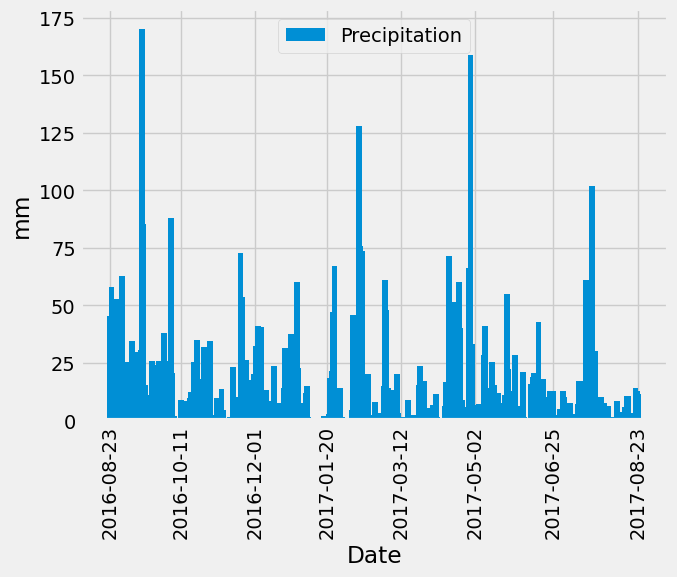

In [30]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
one_year_ago = pd.to_datetime(last_date) - pd.DateOffset(years=1)
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago_str).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(7, 6))
plt.bar(precipitation_df['Date'], precipitation_df['Precipitation'], width=4, label='Precipitation')
plt.xlabel("Date")
plt.ylabel("mm")
n = 7  # Number of date labels to display
step = len(precipitation_df) // n
plt.xticks(precipitation_df['Date'][::step], rotation=90)
plt.legend(loc='upper center')
plt.yticks(range(0, 176, 25))
plt.tight_layout()
plt.show()

In [31]:
# Calculate summary statistics for the precipitation data and label it "Precipitation"
summary_stats = pd.DataFrame(precipitation_df['Precipitation'].describe())
summary_stats.rename(columns={'Precipitation': 'Precipitation'}, inplace=True)

# Print the summary statistics
summary_stats


,Precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [32]:
total_stations = session.query(Station).count()
print("Total number of stations in the dataset:", total_stations)



Total number of stations in the dataset: 9


In [33]:
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

print("Most Active Stations:")
for station, count in active_stations:
    print(f"Station ID: {station}, Observation Count: {count}")


Most Active Stations:
Station ID: USC00519281, Observation Count: 2772
Station ID: USC00519397, Observation Count: 2724
Station ID: USC00513117, Observation Count: 2709
Station ID: USC00519523, Observation Count: 2669
Station ID: USC00516128, Observation Count: 2612
Station ID: USC00514830, Observation Count: 2202
Station ID: USC00511918, Observation Count: 1979
Station ID: USC00517948, Observation Count: 1372
Station ID: USC00518838, Observation Count: 511


In [34]:
total_stations = session.query(Station.station).count()
print("Total number of stations in the dataset:", total_stations)

Total number of stations in the dataset: 9


In [35]:
station_counts = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

most_active_station = station_counts[0][0] 
observation_count = station_counts[0][1]  

temperature_stats = session.query(func.min(Measurement.tobs),
                                   func.max(Measurement.tobs),
                                   func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

print(f"Lowest Temperature: {temperature_stats[0][0]}")
print(f"Highest Temperature: {temperature_stats[0][1]}")
print(f"Average Temperature: {temperature_stats[0][2]}")

Lowest Temperature: 12.2
Highest Temperature: 29.4
Average Temperature: 22.03582251082252


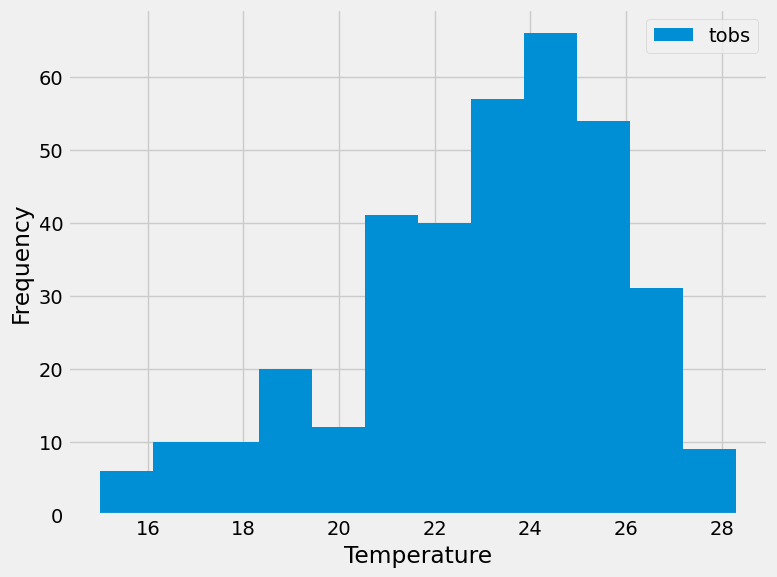

In [36]:
station_counts = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

most_active_station = station_counts[0][0]

last_date = session.query(Measurement.date).filter(Measurement.station == most_active_station).\
    order_by(Measurement.date.desc()).first()[0]
last_date = datetime.strptime(last_date, "%Y-%m-%d")
one_year_ago = last_date - timedelta(days=365)

temperature_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()
temperature_df = pd.DataFrame(temperature_data, columns=["Date", "Temperature"])

#  histogram
plt.figure(figsize=(8, 6))
plt.hist(temperature_df["Temperature"], bins=12, alpha=1)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(["tobs"])
plt.tight_layout()
plt.show()

# Close Session

In [37]:
# Close Session
session.close()